[4137]


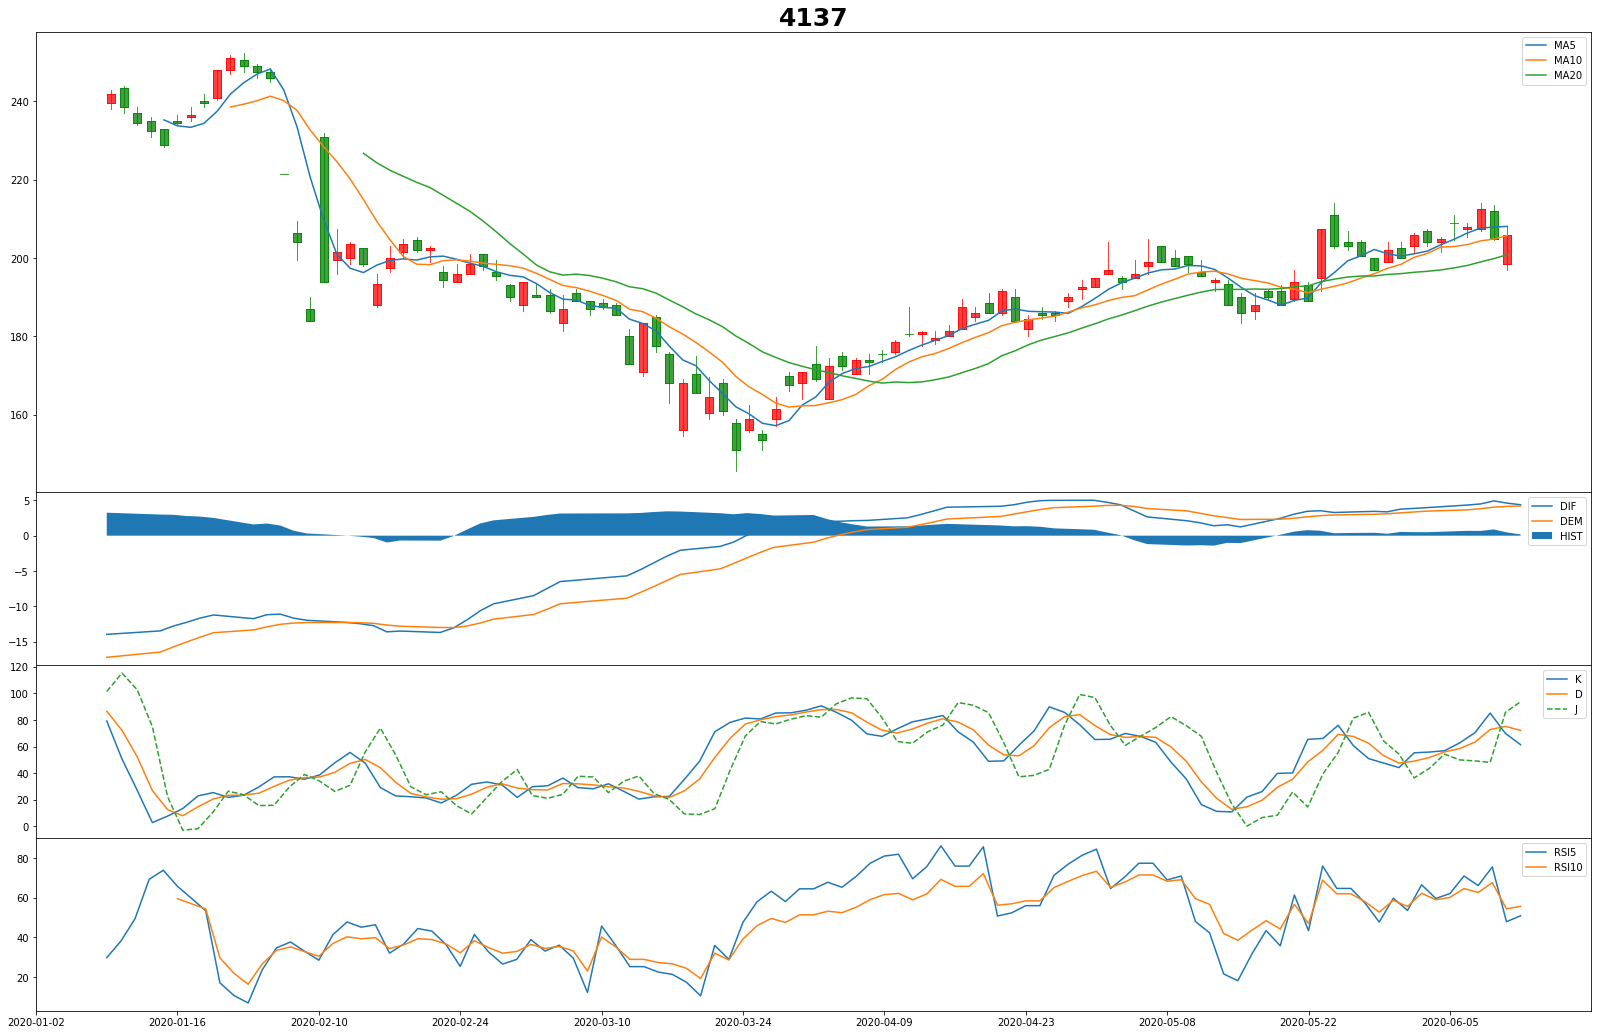

In [2]:
'''
選出前五年(2015-2019)每股盈餘>0、營業利益率>0(代表公司有賺錢)、稅後淨利率>0、ROE>5%、負債比率>0、
速動比率>100、營業活動現金流量(每年)>0之公司，並於2019年再以營收成長率(每年)>10%等做篩選。

由於篩選出的公司過多，所以再根據：近五年來每年殖利率>2%、最新殖利率>近五年平均殖利率、最新殖利率>3%、2019全年EPS>2019所發放之現金股利，
進一步篩選，希望能夠減少公司數，根據上述條件與 20200612 的殖利率（只要有新資料就會抓最新的資料），最後篩出的公司有4間，
股票代碼分別為 [1227, 2395, 4137, 5288]，由於執行程式碼的時間不同，抓下來的殖利率是不同天的資料，
所以最後篩出的公司跟上述4間公司可能會有些微的變動。

若是篩出的公司大於等於5間公司，則在加上前五年(2015-2019)利息保障倍數>5、總資產週轉次數>0.8的公司。

從基本面篩出的公司會在用技術面去分析，挑選較適合的推薦股票：

１．股價(即時) ＞ 均線 MA10
２．股價(即時) ＞ 均線 MA20
３．均線 MA10 與均線 MA20 呈現黃金交叉

最後篩出的股票為 ‘4137麗豐-KY’，再畫出今年技術面分析圖，以利使用者可利用技術面自行進一步判斷。
'''
__author__ = 'JiaYing Wu'
import requests
from bs4 import BeautifulSoup
import pandas as pd
import datetime
import time
import talib
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import mpl_finance as mpf

class model:
    
    def __init__(self):
        tej = pd.read_csv('2015-2019.csv')
        tej.index = tej['代號']
        tej.drop(columns=['代號'],inplace=True)
        tej['來自營運之現金流量'] = tej['來自營運之現金流量'].apply(lambda x: int(x.replace(',','')) if type(x) == str else x)
        self.tej_2019 = tej[tej['年/月'] == '2019/12']
        self.tej_2018 = tej[tej['年/月'] == '2018/12']
        self.tej_2017 = tej[tej['年/月'] == '2017/12']
        self.tej_2016 = tej[tej['年/月'] == '2016/12']
        self.tej_2015 = tej[tej['年/月'] == '2015/12']
        stock2019 = set(self.tej_2019.index)
        stock2018 = set(self.tej_2018.index)
        stock2017 = set(self.tej_2017.index)
        stock2016 = set(self.tej_2016.index)
        stock2015 = set(self.tej_2015.index)
        drop2019 = stock2019.difference(stock2018)|stock2019.difference(stock2017)|stock2019.difference(stock2016)|stock2019.difference(stock2015)
        drop2018 = stock2018.difference(stock2019)|stock2018.difference(stock2017)|stock2018.difference(stock2016)|stock2018.difference(stock2015)
        drop2017 = stock2017.difference(stock2019)|stock2017.difference(stock2018)|stock2017.difference(stock2016)|stock2017.difference(stock2015)
        drop2016 = stock2016.difference(stock2019)|stock2016.difference(stock2018)|stock2016.difference(stock2017)|stock2016.difference(stock2015)
        drop2015 = stock2015.difference(stock2019)|stock2015.difference(stock2018)|stock2015.difference(stock2017)|stock2015.difference(stock2016)
        self.tej_2019 = self.tej_2019.drop(drop2019)
        self.tej_2018 = self.tej_2018.drop(drop2018)
        self.tej_2017 = self.tej_2017.drop(drop2017)
        self.tej_2016 = self.tej_2016.drop(drop2016)
        self.tej_2015 = self.tej_2015.drop(drop2015)
    
    def first(self):
        df = self.tej_2015[(self.tej_2015['營業利益率'] > 0) & (self.tej_2015['稅後淨利率'] > 0) & (self.tej_2015['每股盈餘'] > 0) & (self.tej_2015['ROE(A)－稅後'] > 5)
             & (self.tej_2015['速動比率'] > 100) & (self.tej_2015['負債比率'] > 0) & (self.tej_2015['來自營運之現金流量'] > 0)]
        
        for tejyear in [self.tej_2016,self.tej_2017,self.tej_2018]: 
                df = tejyear.loc[df.index][(tejyear.loc[df.index]['營業利益率'] > 0) & (tejyear.loc[df.index]['稅後淨利率'] > 0) & (tejyear.loc[df.index]['每股盈餘'] > 0) 
                                        & (tejyear.loc[df.index]['ROE(A)－稅後'] > 5) & (tejyear.loc[df.index]['速動比率'] > 100) & (tejyear.loc[df.index]['負債比率'] > 0)
                                        & (tejyear.loc[df.index]['來自營運之現金流量'] > 0)] 
        
        df = self.tej_2019.loc[df.index][(self.tej_2019.loc[df.index]['營業利益率'] > 0) & (self.tej_2019.loc[df.index]['稅後淨利率'] > 0) & (self.tej_2019.loc[df.index]['每股盈餘'] > 0)
                             & (self.tej_2019.loc[df.index]['ROE(A)－稅後'] > 5) & (self.tej_2019.loc[df.index]['速動比率'] > 100) & (self.tej_2019.loc[df.index]['負債比率'] > 0)                           
                            & (self.tej_2019.loc[df.index]['來自營運之現金流量'] > 0) & (self.tej_2019.loc[df.index]['營收成長率'] > 10)
                            & (self.tej_2019.loc[df.index]['每股盈餘'] > self.tej_2019.loc[df.index]['普通股每股現金股利（盈餘及公積）'])]

           
        return df
        
    def first_four_conditions(self,df):
        '''近五年來每年殖利率>2%'''
        for tejyear in [self.tej_2015,self.tej_2016,self.tej_2017,self.tej_2018,self.tej_2019]:
            df = tejyear.loc[df.index][(tejyear.loc[df.index]['股利殖利率'] > 2)]
            
        df1 = self.todayDividendyield()
        df1.columns = df1.columns.droplevel(0)
        df2 = df1[['證券代號','殖利率(%)']]
        df2 = df2[df2['證券代號'].isin(df.index)]
        df2.index = df2['證券代號']
        df2.drop(columns=['證券代號'], inplace=True)
        df2.columns = ['最新殖利率']
        df = pd.concat((df, df2), axis=1, join='inner')
        
        '''最新殖利率>3%
        2019全年EPS>2019所發放之現金股利'''
        df = df[(df['最新殖利率'] >3) & (df['每股盈餘'] > df['普通股每股現金股利（盈餘及公積）'])]
        
        '''最新殖利率>近五年平均殖利率'''
        df_mean = pd.DataFrame(columns=['五年平均股利殖利率'])
        df_mean['五年平均股利殖利率'] = ((self.tej_2015.loc[df.index]['股利殖利率']+self.tej_2016.loc[df.index]['股利殖利率']
                                 +self.tej_2017.loc[df.index]['股利殖利率']+self.tej_2018.loc[df.index]['股利殖利率']+self.tej_2019.loc[df.index]['股利殖利率'])/5)
        df = pd.concat((df, df_mean), axis=1, join='inner')
        df = df[df['最新殖利率']>df['五年平均股利殖利率']]
        symbolId = list(df.index)
        
        return df,symbolId
    
    def todayDividendyield(self):  
        '''爬取每天最新的殖利率，如果今日還未收盤則爬取昨天，如遇未開市日則爬取最後收盤資料'''
        today = datetime.datetime.today()
        while True:
            try:
                y = str(today.year)
                m = str(today.month)
                if len(m) == 1:
                    m = '0' + m
                d = str(today.day)
                url ='https://www.twse.com.tw/exchangeReport/BWIBBU_d?response=html&date=' + y + m + d + '&selectType=ALL'
                r = requests.post(url)
                df1 = pd.read_html(r.text)[0].fillna("")
                return df1
            
            except ValueError:
                today = today - datetime.timedelta(days = 1)
                time.sleep(5)
                
    def ma(self,symbolId):
        '''
        １．股價(即時) ＞ 均線 MA10
        ２．股價(即時) ＞ 均線 MA20
        ３．均線 MA10 與 均線 MA20 呈現黃金交叉
        '''
        output=[]
        for stock in symbolId:
            stock = str(stock)
            url = 'https://tw.stock.yahoo.com/q/q?s=' + stock
            list_req = requests.get(url)
            soup = BeautifulSoup(list_req.content, "html.parser")
            get_stock_price= soup.findAll('b')[1].text 

            end = datetime.datetime.today()
            start = end - datetime.timedelta(days = 120)

            df2 = web.DataReader([stock+'.TW'], 'yahoo', start, end)

            ma20=talib.SMA(df2['Close'][stock+'.TW'],timeperiod=20)[-1]
            ma10=talib.SMA(df2['Close'][stock+'.TW'],timeperiod=10)[-1]

            if ma20 < float(get_stock_price):
                if ma10 < float(get_stock_price):
                    if ma20 < ma10 : #黃金交叉
                        output.append(int(stock))
        return output
    
    def second(self,df):
        
        for tejyear in [tej_2015,tej_2016,tej_2017,tej_2018,tej_2019]:
            df = tejyear.loc[df.index][(tejyear.loc[df.index]['利息保障倍數'] > 5) & (tejyear.loc[df.index]['總資產週轉次數'] > 0.8)]

        return df
    
    def kd(self,df,stock):
        K,D = talib.STOCH(high = np.array(df['High'][stock+'.TW']), 
                low = np.array(df['Low'][stock+'.TW']), 
                close = np.array(df['Close'][stock+'.TW']),
                fastk_period=9,
                slowk_period=3,
                slowk_matype=0,
                slowd_period=3,
                slowd_matype=0)
        J = np.array(3*D-2*K)

        k = pd.DataFrame(K)
        d = pd.DataFrame(D)
        j = pd.DataFrame(J)
        k.index = df.index
        d.index = df.index
        j.index = df.index
        
        return k,d,j

    
    def plot(self,symbolId):
        start = datetime.datetime(2020,1, 1)
        end = datetime.datetime.today()
        for stock in symbolId:
            stock = str(stock)
            df = web.DataReader([stock+'.TW'], 'yahoo', start, end)
            
            ma5=talib.SMA(df['Close'][stock+'.TW'],timeperiod=5)
            ma20=talib.SMA(df['Close'][stock+'.TW'],timeperiod=20)
            ma10=talib.SMA(df['Close'][stock+'.TW'],timeperiod=10)
            
            dif, dem, hist = talib.MACD(df['Close'][stock+'.TW'])
            ema12 = talib.EMA(df['Close'][stock+'.TW'], 12)
            ema26 = talib.EMA(df['Close'][stock+'.TW'], 26)
            
            rsi5 = talib.RSI(df['Close'][stock+'.TW'].values, 5)
            rsi10 = talib.RSI(df['Close'][stock+'.TW'].values, 10)
            
            k,d,j = self.kd(df,stock)
            
            df.index = df.index.to_series().apply(lambda x: x.strftime('%Y-%m-%d'))
            
            #畫圖
            fig = plt.figure(figsize=(24, 16))
            ax1 = fig.add_axes([0.05,0.55,0.9,0.4])
            plt.title(stock,fontsize=25,fontweight='bold')
            ax2 = fig.add_axes([0.05,0.4,0.9,0.15])
            ax3 = fig.add_axes([0.05,0.25,0.9,0.15])
            ax4 = fig.add_axes([0.05,0.1,0.9,0.15])

            mpf.candlestick2_ochl(ax1, df['Open'][stock+'.TW'], df['Close'][stock+'.TW'], df['High'][stock+'.TW'],
                                  df['Low'][stock+'.TW'], width=0.6, colorup='r', colordown='g', alpha=0.75)

            ax1.plot(ma5.values,label='MA5')
            ax1.plot(ma10.values,label='MA10')
            ax1.plot(ma20.values,label='MA20')
            ax1.legend()


            ax2.plot(dif,label='DIF')
            ax2.plot(dem,label='DEM')
            ax2.fill_between(hist.index,0,hist,label='HIST')
            ax2.legend()

            ax3.plot(k.values, label='K')
            ax3.plot(d.values, label='D')
            ax3.plot(j.values, '--',label='J')
            ax3.legend()

            ax4.plot(rsi5, label='RSI5')
            ax4.plot(rsi10, label='RSI10')
            ax4.legend()

            ax4.set_xticks(range(0, len(df.index),10))
            ax4.set_xticklabels(df.index[::10])
            plt.savefig('技術分析圖'+stock+'.png')
            plt.show()

            

        
if __name__ == '__main__':
    chose = model()
    data = chose.first()
    data,symbolId = chose.first_four_conditions(data)
    symbolId2 = chose.ma(symbolId)
    if symbolId2:
        symbolId = symbolId2
    data = data.loc[symbolId]
    if len(symbolId) >= 5:
        data = chose.second(data)
        symbolId = list(data.index)
    print(symbolId) #最後篩選出來的股票
    chose.plot(symbolId)

In [3]:
data

,名稱,年/月,營業利益率,稅後淨利率,每股盈餘,ROE(A)－稅後,速動比率,負債比率,來自營運之現金流量,營收成長率,股利殖利率,現金股利率,普通股每股現金股利（盈餘及公積）,交易所主產業代碼,最新殖利率,五年平均股利殖利率
4137,麗豐-KY,2019/12,34.81,27.87,18.02,33.72,175.93,46.26,1833543.0,12.24,5.46,5.46,13.0,M1700,6.31,4.528
